# Pile Splitting

In [1]:
import transformer_lens, torch, tqdm, copy
import numpy as np
from pathlib import Path
from toolz import compose
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, evaluation

In [36]:
model_type="gpt-neo-1.3B"
torch.set_grad_enabled(False)
model = modelHandlers.load_model(model_type=model_type, DEVICE="cuda")

Loaded pretrained model gpt-neo-1.3B into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']


## Loading seqs from the Pile

https://github.com/ethz-spylab/lm_memorization_data


filtering tokens and eos: 50256
count_ranges [[1, 10000000]]
toks_NI shape: torch.Size([10000, 100]), with max count 76329


Text(0, 0.5, 'count')

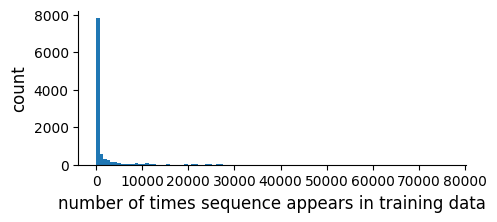

In [3]:
filter_str = ["TripAdvisor", "href", "license", "copyright", "software", "manuscript", "submission", "distribution", "disclaimed","limited"]
filter_toks = model.to_tokens(dataLoaders.expand_filter_list(filter_str))
toks_NI, counts_N, idcs_N = dataLoaders.preprocess_pile_seqs(seq_length=100, n_seqs=10000, uni_tok_frac=0.3, filter_toks=filter_toks, count_ranges=[[1,10000000]], k_uniform=None)
#toks_NI, counts_N = dataLoaders.load_pile_seqs(seq_length=100, n_seqs=10000, uni_tok_frac=0.5, filter_toks=None, count_ranges=None, k_uniform=None)
print(f"toks_NI shape: {toks_NI.shape}, with max count {max(counts_N).item()}")

fig, ax = plt.subplots(1, 1, figsize=(5, 2), gridspec_kw={'hspace': 0.4})
counts, bins = np.histogram(counts_N, bins=100)
_ = ax.hist(bins[:-1], bins, weights=counts)
ax.set_xlabel('number of times sequence appears in training data', fontsize=12)
ax.set_ylabel('count', fontsize=12)

## Likelihood- and Decoding-based Splitting Methods

In [4]:
(mean_nll_N, minK_nll_N),(preds_NI, trues_NI) = evaluation.evaluate_nll_greedy(model, toks_NI, batch_size=50, tqdm_disable=False)

100%|██████████| 200/200 [05:56<00:00,  1.78s/it]


In [5]:
em_N = evaluation.compute_exact_match(preds_NI, trues_NI, until_wrong=False)

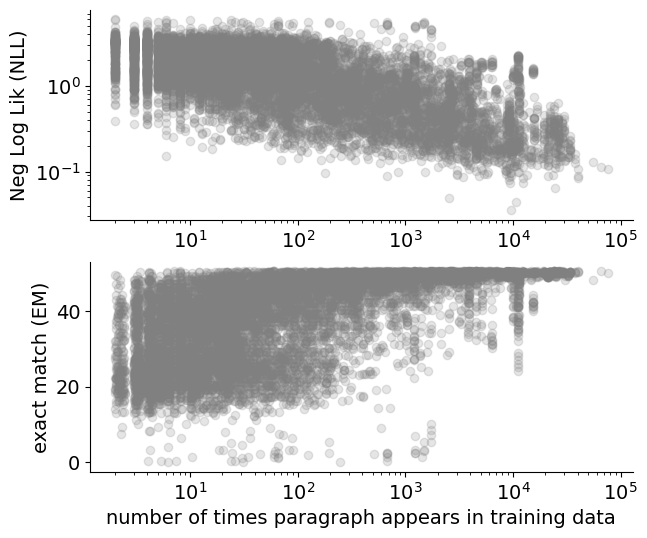

In [115]:
fontsize = 14
fig, axs = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'hspace': 0.2})

## NLL
x = counts_N.cpu().numpy()
mean = axs[0].scatter(x, mean_nll_N.detach().mean(-1).cpu().numpy(), color="grey", alpha=0.2, label="mean NLL")
#minK = ax.scatter(x, minK_nll_N.detach().mean(-1).cpu().numpy(), alpha=0.2, label="minK NLL")
#axs[0].legend(handles=[minK, mean], loc='upper right') #minK, mean, 
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='major', labelsize=fontsize)
#axs[0].set_xlabel('number of times sequence appears in training data', fontsize=fontsize)
axs[0].set_ylabel('Neg Log Lik (NLL)', fontsize=fontsize)

## Exact Match
std_jit = 0.5
x = counts_N.numpy() + np.random.uniform(0, std_jit, em_N.shape)
y = em_N.detach().cpu().numpy() + np.random.uniform(0, std_jit, em_N.shape)
em = axs[1].scatter(x, y, color="grey", alpha=0.2, label="exact match acc")
axs[1].set_xscale('log')
axs[1].tick_params(axis='both', which='major', labelsize=fontsize)

axs[1].set_xlabel('number of times paragraph appears in training data', fontsize=fontsize)
axs[1].set_ylabel('exact match (EM)', fontsize=fontsize)

fig.savefig(f"{model_type}_nll_em.pdf", dpi=200, bbox_inches="tight")

In [33]:
#nll_idcs = torch.where(mean_nll_N.mean(-1) < 2, 1, 0).nonzero().squeeze()
#print(f"n items: {nll_idcs.shape}\nwith mean nll {mean_nll_N[nll_idcs].mean(-1)}\n\nmin nll strings: {model.to_string(toks_NI[nll_idcs[:10]])}")

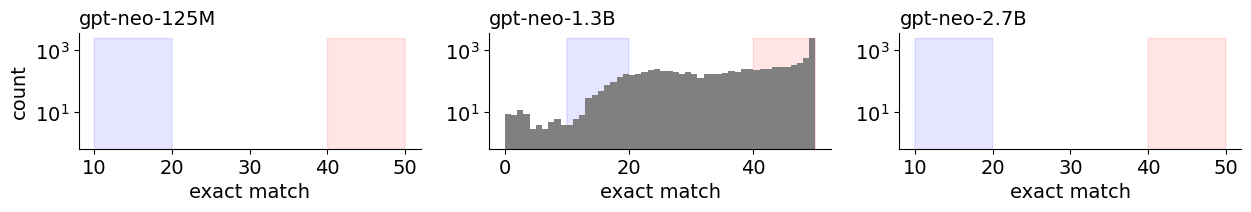

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(15, 1.5), gridspec_kw={'hspace': 0.4})
fontsize = 14

axs[0].set_yscale('log')
axs[0].set_title("gpt-neo-125M", fontsize=fontsize, loc="left")
axs[0].set_xlabel('exact match', fontsize=fontsize)
axs[0].set_ylabel('count', fontsize=fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=fontsize)
axs[0].fill_betweenx(np.arange(0,counts[-1]), 10, 20, color='blue', alpha=0.1, zorder=0)
axs[0].fill_betweenx(np.arange(0,counts[-1]), 40, 50, color='red', alpha=0.1, zorder=0)

counts, bins = np.histogram(em_N, bins=50)
_ = axs[1].hist(bins[:-1], bins, color="grey", weights=counts)
axs[1].set_yscale('log')
axs[1].set_title("gpt-neo-1.3B", fontsize=fontsize, loc="left")
axs[1].set_xlabel('exact match', fontsize=fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=fontsize)
axs[1].fill_betweenx(np.arange(0,counts[-1]), 10, 20, color='blue', alpha=0.1, zorder=0)
axs[1].fill_betweenx(np.arange(0,counts[-1]), 40, 50, color='red', alpha=0.1, zorder=0)

axs[2].set_yscale('log')
axs[2].set_title("gpt-neo-2.7B", fontsize=fontsize, loc="left")
axs[2].set_xlabel('exact match', fontsize=fontsize)
axs[2].tick_params(axis='both', which='major', labelsize=fontsize)
axs[2].fill_betweenx(np.arange(0,counts[-1]), 10, 20, color='blue', alpha=0.1, zorder=0)
axs[2].fill_betweenx(np.arange(0,counts[-1]), 40, 50, color='red', alpha=0.1, zorder=0)

file_name = f'/home/jupyter/paraMem/data/pile_splits/{model_type}/em_counts.pt'
dataLoaders.store_tensor(em_N, file_name, add_meta=None)

fig.savefig(f"{dataLoaders.ROOT}/results/em_split.pdf", dpi=200, bbox_inches="tight")

In [112]:
em_idcs  = torch.where((10 <= em_N) & (em_N <= 20), 1, 0).nonzero().squeeze()
print(f"n items: {em_idcs.shape}\nwith mean nll {mean_nll_N[em_idcs].mean(-1)}\n\nexact match strings: {model.to_string(toks_NI[em_idcs[:20]])}")
df = pd.DataFrame(list(zip(model.to_string(toks_NI[em_idcs]), em_idcs.tolist(), counts_N[em_idcs].tolist())), columns=["paragraph","id","count"])

n items: torch.Size([779])
with mean nll tensor([4.3022, 3.1995, 3.5019, 3.3365, 3.3285, 3.3066, 2.8311, 3.4462, 3.4844,
        4.0842, 2.9417, 4.1159, 3.2203, 3.8002, 3.0762, 3.0951, 4.1748, 3.6003,
        3.6896, 2.2392, 3.6948, 4.0484, 2.7527, 3.0804, 3.3085, 3.2024, 3.1946,
        3.8342, 3.2915, 4.4765, 3.1260, 3.7497, 3.3427, 3.0012, 3.3951, 3.1739,
        3.2992, 3.0117, 3.4847, 3.2557, 4.3278, 3.6304, 3.2219, 3.5193, 3.3723,
        2.8488, 3.1163, 3.2677, 3.4193, 4.0409, 3.2372, 3.1820, 3.0707, 3.1089,
        4.6234, 3.4723, 3.1699, 3.0648, 3.2843, 4.1330, 3.0689, 3.0830, 3.8001,
        3.0817, 3.6935, 2.5982, 3.3699, 3.1566, 3.7311, 2.9854, 2.9533, 3.1723,
        3.8614, 3.6846, 3.7891, 3.3929, 3.7299, 4.1286, 3.9106, 3.5855, 2.6013,
        3.0770, 4.2529, 2.9023, 3.0681, 3.5730, 3.3039, 4.2751, 2.9921, 3.0004,
        3.5462, 2.7082, 3.0647, 3.3687, 2.9551, 4.3975, 3.9299, 3.4696, 3.3640,
        3.1973, 2.9286, 4.1228, 2.5798, 3.2032, 4.3806, 3.0780, 3.4062, 4.0743,

In [114]:
df.to_csv(f'/home/jupyter/paraMem/data/pile_splits/{model_type}/mem_str.csv', index=False)

file_name = f'/home/jupyter/paraMem/data/pile_splits/{model_type}/non_mem.pt'
dataLoaders.store_tensor(em_idcs, file_name, idcs_N, add_meta={})

In [111]:
def store_splits(em_N:torch.tensor, idcs_N:torch.tensor, path_name:str, file_name:str=None, idx_list:list=[[0,10],[10,20],[20,30],[30,40],[40,50]]):
    for idcs in idx_list:
        em_idcs = torch.where((idcs[0] <= em_N) & (em_N <= idcs[1]), 1, 0).nonzero().squeeze()
        print(f"em {idcs[0]}-{idcs[1]}---n items: {em_idcs.shape}\nwith mean nll {mean_nll_N[em_idcs].mean()}\n\nexact match strings: {model.to_string(toks_NI[em_idcs[:2]])}\n\n")
        if len(idx_list) > 1:
            file_name = f"{str(idcs[0])}_{str(idcs[1])}"
        file_name = path_name + "/" + file_name + ".pt"
        dataLoaders.store_tensor(em_idcs, file_name, idcs_N, add_meta={})
    
path_name = f'/home/jupyter/paraMem/data/pile_splits/{model_type}/ranges'
store_splits(em_N, idcs_N, path_name=path_name)

em 0-10---n items: torch.Size([67])
with mean nll 5.062652111053467

exact match strings: ['zeXhg66quOLAzjXcCAwEAAQJBAKcRxH9wuglYLBdI/0OT\nBLzfWPZCEw1vZmMR2FF1Fm8nkNOVDPleeVGTWoOEcYYlQbpTmkGSxJ6ya+hqRi6x\ngoECIQDx3+X49fwpL6B5qp', '67757fb3532b289550894da6dce4817a4e07f4d56877a1102ffcc8befa5c9f8fca6a4574d93ff70376c8861e0f8108cf907fce77ecb49728f86f034f80224b9695682e0824462f76cdb1fd1af151337b0d854']


em 10-20---n items: torch.Size([779])
with mean nll 3.3699536323547363

exact match strings: ['700. The non-vote represented the senators disapproval of the proposed budget. Most of the senators voiced their criticisms to the administration panel which in- In the wake of past, unsuccessful attempts to influence the Administration, the Undergraduate Student Assembly (USA) refused to vote on the College\'s 1990-91 proposed budget, which includes a $850 tuition hike, during an open forum Tuesday evening.Roux alluded to recent ex- US A president Vince Roux 90\' recommended the non-vote. "', " rea